# Contents

### 1 Import Packages


### 2 Load Data

#### 2.1 Checking for NULLs

#### 2.2 Handling NULLs

#### 2.3 Handling dates


### 3 Handling Data

#### 3.1 Set date as index

#### 3.2 Train/Test Split

#### 3.3 Resample Data


### 4 Checking Data

#### 4.1 Visualizing the time series (Only Min Temp column)

#### 4.2 Decomposing the Time Series

#### 4.3 Stationarity Tests - Augmented Dickey Fuller Test (ADF)


### 5 Determining the parameters for ARIMA (p, q)

#### 5.1 Auto correlation plots

#### 5.2 ARIMA (Trying with the selected parameters)

#### 5.3 Model Diagnostics (Residuals)

#### 5.4 Forecasting on a Train/Test split

#### 5.5 Plotting the forecast values and the true values

#### 5.6 Plotting only the actual and forecast values

#### 5.7 Performance Metrics for the forecast


### 6 Auto ARIMA

#### 6.1 ARIMA without Seasonality

#### 6.2 Residual Plots - Auto ARIMA (Non Seasonal)

#### 6.3 Plotting the forecasts

#### 6.4 Auto ARIMA with Seasonality

#### 6.5 Plotting the forecasts (Auto ARIMA with Seasonality)

#### 6.6 Performance Metrics for the forecast

### 1 Import Packages

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

%config Completer.use_jedi = False

### 2 Load Data

In [2]:
perthTemp = pd.read_csv("C:\\Users\\Sarat\\Desktop\\Time Series Forecasting\\data\\PerthTemperatures.csv")

#### 2.1 Checking for NULLs

In [3]:
perthTemp.isnull().sum()

Year                               1
Month                              1
Day                                1
Minimum temperature (Degree C)    76
Maximum temperature (Degree C)    31
Rainfall amount (millimetres)      0
Quality                           31
dtype: int64

In [4]:
perthTemp.drop(columns=['Quality'], inplace=True)

#### 2.2 Handling NULLs

In [5]:
perthTemp.isnull().sum()

Year                               1
Month                              1
Day                                1
Minimum temperature (Degree C)    76
Maximum temperature (Degree C)    31
Rainfall amount (millimetres)      0
dtype: int64

In [6]:
perthTemp.drop(perthTemp.tail(1).index, inplace=True)

#### Filling NULLs

In [7]:
perthTemp.fillna(method='ffill', inplace = True)

In [8]:
perthTemp.isnull().sum()

Year                              0
Month                             0
Day                               0
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    0
Rainfall amount (millimetres)     0
dtype: int64

#### 2.3 Handling dates

In [9]:
perthTemp

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
0,1944.0,6.0,3.0,11.0,22.3,0.0
1,1944.0,6.0,4.0,12.2,23.4,0.0
2,1944.0,6.0,5.0,12.0,20.3,2.0
3,1944.0,6.0,6.0,7.4,18.7,3.3
4,1944.0,6.0,7.0,5.9,21.3,0.3
...,...,...,...,...,...,...
27641,2020.0,2.0,6.0,21.0,32.6,0.0
27642,2020.0,2.0,7.0,20.7,30.6,0.0
27643,2020.0,2.0,8.0,19.6,28.2,0.0
27644,2020.0,2.0,9.0,14.1,29.8,0.0


#### Merging the multi column dates into one column

In [10]:
perthTemp['Date'] = pd.to_datetime(perthTemp[['Year', 'Month', 'Day']])

In [11]:
perthTemp.drop(columns=['Year', 'Month', 'Day'], inplace = True)

In [12]:
perthTemp.dtypes

Minimum temperature (Degree C)           float64
Maximum temperature (Degree C)           float64
Rainfall amount (millimetres)            float64
Date                              datetime64[ns]
dtype: object

### 3 Handling Data

#### 3.1 Set date as index

In [13]:
perthTemp_2 = perthTemp.set_index('Date')

In [14]:
perthTemp_2

,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
Date,,,
1944-06-03,11.0,22.3,0.0
1944-06-04,12.2,23.4,0.0
1944-06-05,12.0,20.3,2.0
1944-06-06,7.4,18.7,3.3
1944-06-07,5.9,21.3,0.3
...,...,...,...
2020-02-06,21.0,32.6,0.0
2020-02-07,20.7,30.6,0.0
2020-02-08,19.6,28.2,0.0


#### 3.2 Train/Test Split

#### Since we shouldn't shuffle the dataset we can just split the dataset using the date index

In [15]:
perthTemp_Train = perthTemp_2[:'2010-12-31']

perthTemp_Test = perthTemp_2['2011-01-01':]

#### 3.3 Resample Data

In [16]:
perthTemp_Train_MS = perthTemp_Train.resample('MS').mean()
perthTemp_Test_MS = perthTemp_Test.resample('MS').mean()

In [17]:
perthTemp_Train_MS.rename(columns={'Minimum temperature (Degree C)':'mintemp',
                                   'Maximum temperature (Degree C)':'maxtemp',
                                   'Rainfall amount (millimetres)':'rainfall'}, inplace = True)

perthTemp_Test_MS.rename(columns={'Minimum temperature (Degree C)':'mintemp',
                                   'Maximum temperature (Degree C)':'maxtemp',
                                   'Rainfall amount (millimetres)':'rainfall'}, inplace = True)

perthTemp_Train_MS

,mintemp,maxtemp,rainfall
Date,,,
1944-06-01,8.107143,20.421429,2.750000
1944-07-01,7.700000,18.209677,5.722581
1944-08-01,7.093548,19.509677,3.493548
1944-09-01,7.870000,20.316667,1.770000
1944-10-01,10.487097,24.648387,0.545161
...,...,...,...
2010-08-01,5.980645,19.454839,1.935484
2010-09-01,8.016667,22.140000,0.926667
2010-10-01,9.703226,25.129032,0.812903


### 4 Checking Data

#### 4.1 Visualizing the time series (Only one column - Univariate)

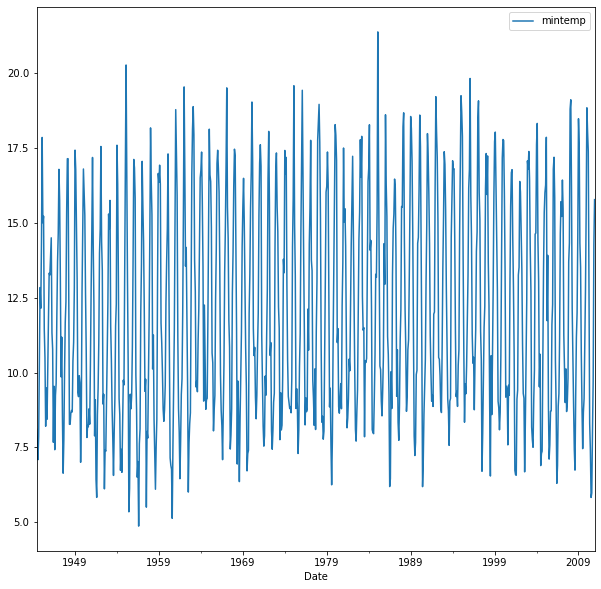

In [18]:
perthTemp_Train_MS[['mintemp']].plot(figsize=(10, 10))
plt.show()

#### 4.2 Decomposing the Time Series - Into trend, seasonality and noise

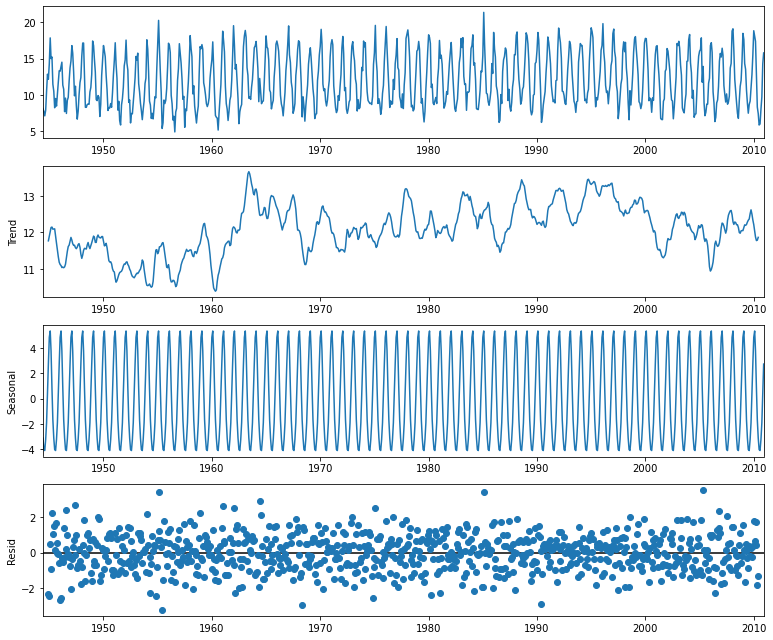

In [19]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(perthTemp_Train_MS[['mintemp']], model='additive')
fig = decomposition.plot()
plt.show()

#### 4.3 Stationarity Tests - Augmented Dickey Fuller Test (ADF)

In [20]:
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

##### Checking our data

In [21]:
adf_test(perthTemp_Train_MS[['mintemp']])

Test Statistic           -3.971340
p-value                   0.001568
# Lags                   21.000000
# Observations          777.000000
Critical Value (1%)      -3.438794
Critical Value (5%)      -2.865267
Critical Value (10%)     -2.568755
dtype: float64
 Series is Stationary


##### Since the series is stationary we need not difference it

### 5 Determining the parameters for ARIMA (p, q)

#### 5.1 Auto correlation plots

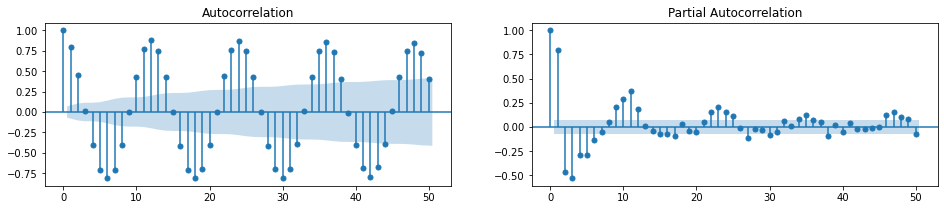

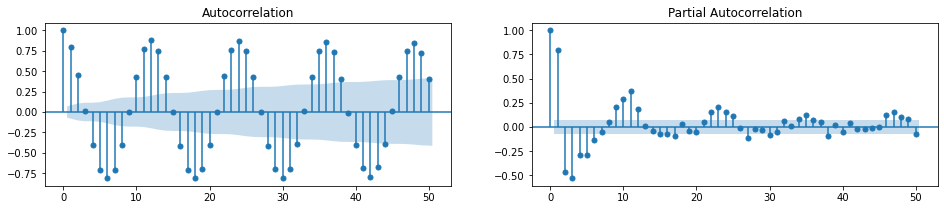

In [22]:
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(perthTemp_Train_MS.mintemp.tolist(), lags=50, ax=axes[0])
plot_pacf(perthTemp_Train_MS.mintemp.tolist(), lags=50, ax=axes[1])

##### The PACF plot shows the 2nd lag cutting off, therefore the p value is 2
##### The ACF plot shows the 3rd lag cutting off, therefore the q value is 3

#### 5.2 ARIMA (Trying with the selected parameters)

In [23]:
# p = 2, d = 0, q = 3

model = None
model = ARIMA(perthTemp_Train_MS[['mintemp']], order=(2,0,3))
model_fit = model.fit()

print(model_fit.summary())

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                mintemp   No. Observations:                  799
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1335.606
Date:                Wed, 26 May 2021   AIC                           2685.212
Time:                        15:10:16   BIC                           2717.995
Sample:                    06-01-1944   HQIC                          2697.806
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0805      0.060    202.715      0.000      11.964      12.197
ar.L1          1.7319      0.000   8096.725      0.000       1.731       1.732
ar.L2         -0.9999   9.78e-05  -1.02e+04      0.0

#### 5.3 Model Diagnostics (Residuals)

#### Residuals are the errors of the forecast. The difference between the actual values and the values of the fitted model
#### We want the residuals to be normally distributed and show now patterns. They must be random.
#### The plots below show the distribution of residuals

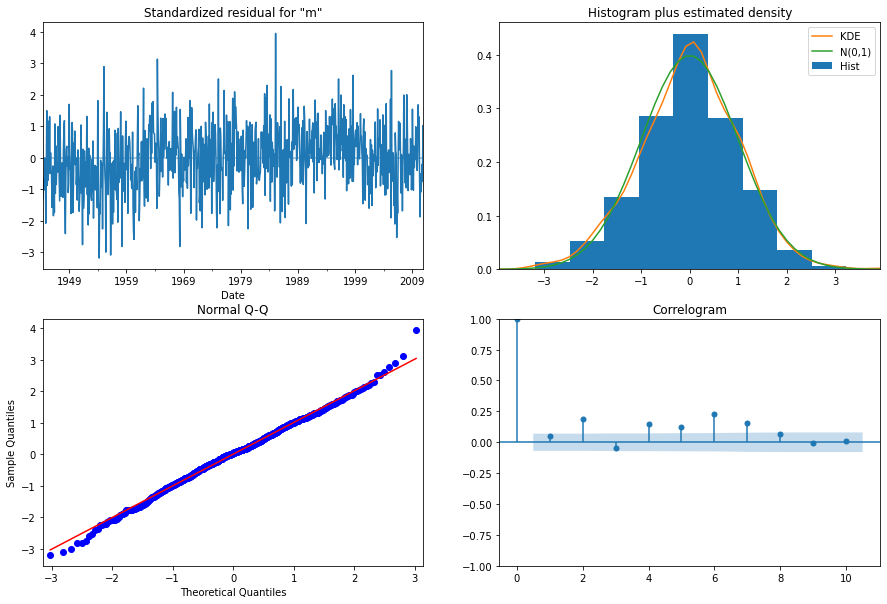

In [24]:
model_fit.plot_diagnostics(figsize=(15,10))
plt.show()

#### 5.4 Forecasting on a Train/Test split

In [25]:
model = None
model = ARIMA(perthTemp_Train_MS[['mintemp']], order=(2, 0, 3))  
fitted = model.fit()

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 5.5 Plotting the forecast values and the true values

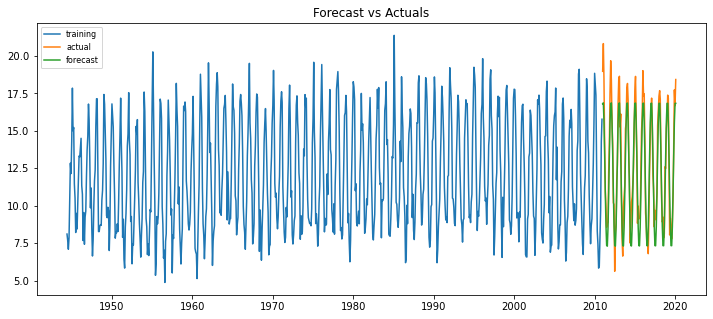

In [26]:
# Forecast
fc = fitted.forecast(len(perthTemp_Test_MS), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=perthTemp_Test_MS[['mintemp']].index)

# Plot
plt.figure(figsize=(12,5))
# Training data
plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
# Test data actual values
plt.plot(perthTemp_Test_MS[['mintemp']], label='actual')
# Forecasted values
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 5.6 Plotting only the actual and forecast values

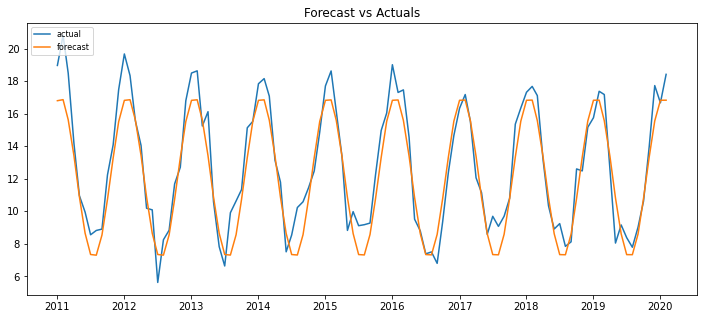

In [27]:
# Forecast
fc = fitted.forecast(len(perthTemp_Test_MS), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=perthTemp_Test_MS[['mintemp']].index)

# Plot
plt.figure(figsize=(12,5))
# plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(perthTemp_Test_MS[['mintemp']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 5.7 Performance Metrics for the forecast

#### Mean Absolute Error and Mean Absolute Percentage Error

In [28]:
mae = mean_absolute_error(fc, perthTemp_Test_MS[['mintemp']].values)
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(fc, perthTemp_Test_MS[['mintemp']].values)
print('MAPE: %.3f' % mape)

MAE: 1.116
MAPE: 0.101


### 6 Auto ARIMA

#### This model will determine the best values for the parameters p, q, d

#### 6.1 ARIMA without Seasonality

In [29]:
model = None
model = pm.auto_arima(perthTemp_Train_MS[['mintemp']], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=9, max_q=9, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3543.346, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6316.154, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3597.869, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5405.286, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3499.724, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3510.720, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3459.058, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3475.206, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3097.669, Time=0.81 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3431.579, Time=0.15 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=3019.639, Time=0.78 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3380.152, Time=0.15 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=2898.643, Time=0.87 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(7,0,1)(0,0,0)[0]             : 

#### 6.2 Residual Plots - Auto ARIMA (Non Seasonal)

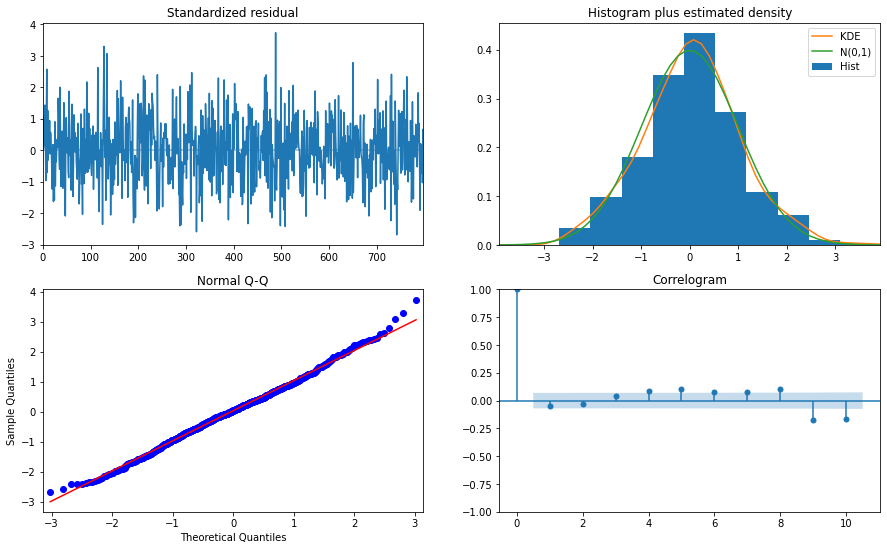

In [30]:
model.plot_diagnostics(figsize=(15,9))
plt.show()

#### 6.3 Plotting the forecasts

In [31]:
fitted = None

fitted = model.fit(perthTemp_Train_MS[['mintemp']])

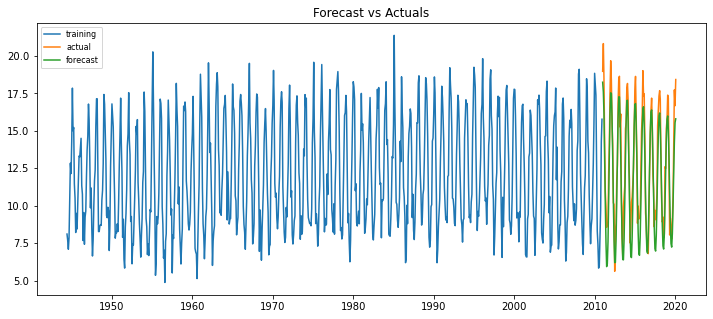

In [32]:
# Forecast
fc = fitted.predict(len(perthTemp_Test_MS))  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=perthTemp_Test_MS.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(perthTemp_Test_MS[['mintemp']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

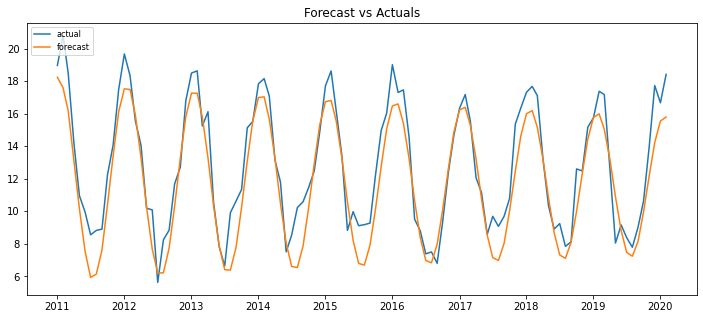

In [33]:
# Forecast
fc = fitted.predict(len(perthTemp_Test_MS))  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=perthTemp_Test_MS.index)

# Plot
plt.figure(figsize=(12,5))
# plt.plot(perthTemp_Train_MS[['mintemp']], label='training')
plt.plot(perthTemp_Test_MS[['mintemp']], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 6.4 Auto ARIMA with Seasonality

In [34]:
# Seasonal - fit stepwise auto-ARIMA
smodel = None
smodel = pm.auto_arima(perthTemp_Train_MS[['mintemp']], start_p=1, start_q=1,
                         test='adf',
                         max_p=9, max_q=9, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3008.747, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2761.654, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3006.750, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2977.871, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2684.168, Time=0.73 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2716.904, Time=0.75 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2669.270, Time=0.86 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=2749.610, Time=0.42 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.86 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=2671.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  799
Model:             SARIMAX(2, 0, 3)x(2, 1, [], 12)   Log Likelihood               -1324.530
Date:                             Wed, 26 May 2021   AIC                           2665.060
Time:                                     15:13:05   BIC                           2702.405
Sample:                                          0   HQIC                          2679.417
                                             - 799                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1139      0.275      0.414      0.679      -0.426       0.653
ar.L2          0.5438      0.161      3.385      0.001       0.229       0.859
ma.L1          0.0692      0.277      0.250      0.803      -0.473       0.612
ma.L2         -0.3902      0.152     -2.563      0.010      -0.689      -0.092
ma.L3         -0.0903      0.062     -1.452      0.147      -0.212       0.032
ar.S.L12      -0.6554      0.033    -19.697      0.000      -0.721      -0.590
ar.S.L24      -0.3210      0.034     -9.316      0.000      -0.389      -0.253
sigma2         1.6828      0.086     19.587      0.000       1.514       1.851
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.91   Prob(JB):                         0.74
Heteroskedasticity (H):               0.81   Skew:                             0.07
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 6.5 Plotting the forecasts (Auto ARIMA with Seasonality)

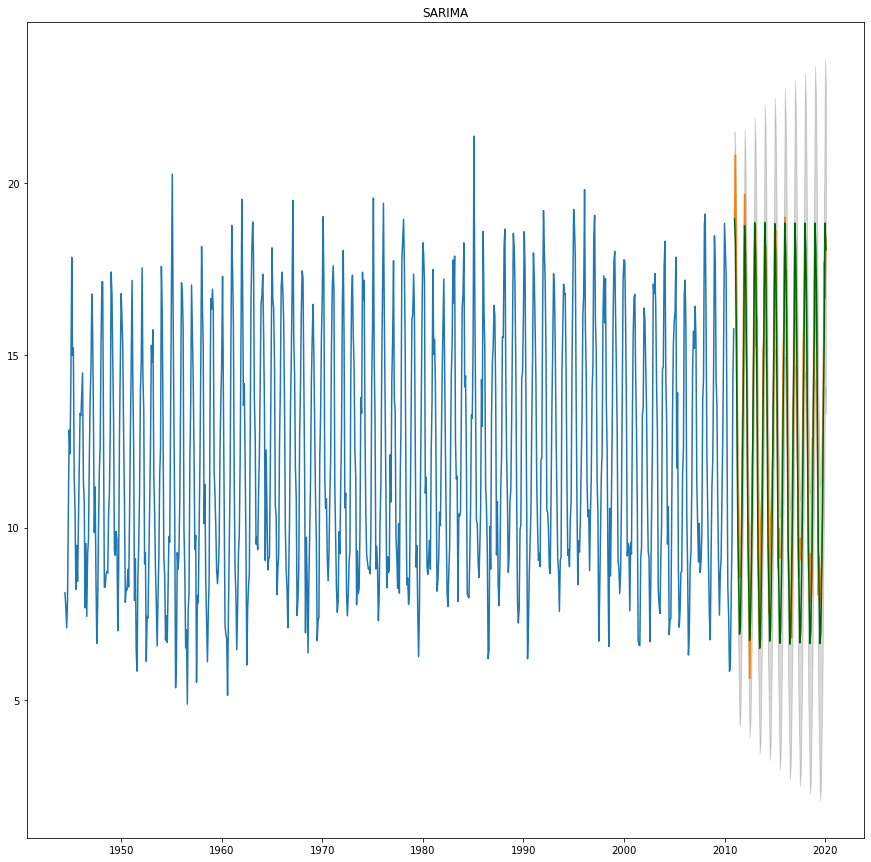

In [35]:
# Forecast
n_periods = len(perthTemp_Test_MS)
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = perthTemp_Test_MS.index

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,15))
plt.plot(perthTemp_Train_MS[['mintemp']])
plt.plot(perthTemp_Test_MS[['mintemp']])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA")
plt.show()

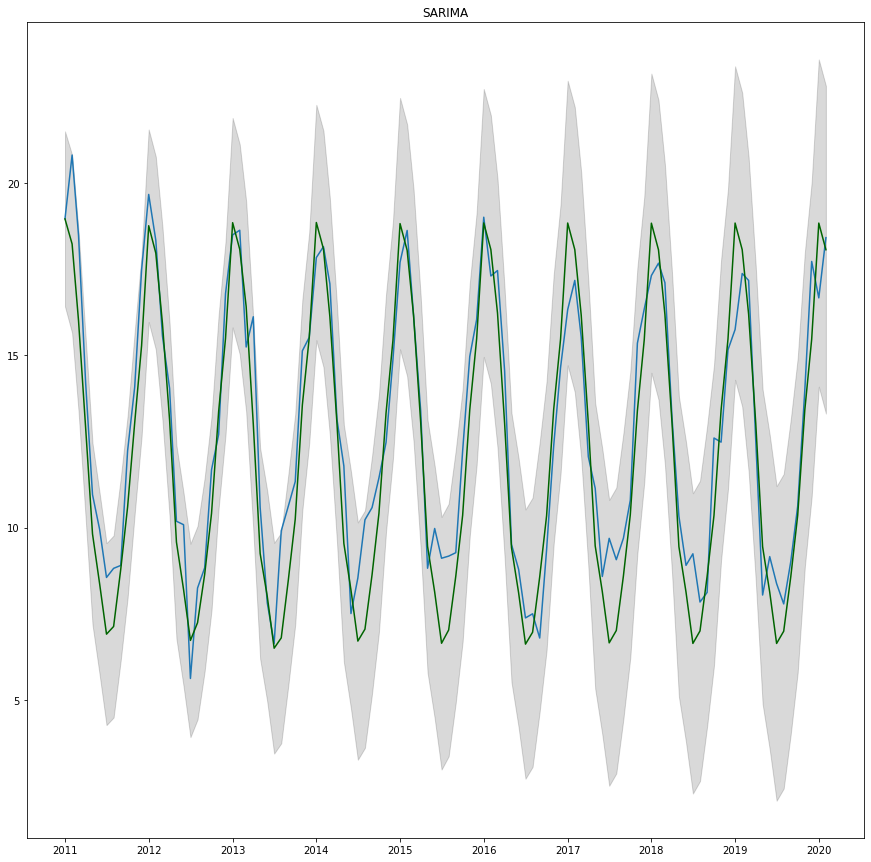

In [36]:
# Plot
plt.figure(figsize=(15,15))
# plt.plot(perthTemp_Train_MS[['mintemp']])
plt.plot(perthTemp_Test_MS[['mintemp']])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA")
plt.show()

#### 6.6 Performance Metrics for the forecast

In [37]:
mae = mean_absolute_error(perthTemp_Test_MS['mintemp'], fitted_series)
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(perthTemp_Test_MS['mintemp'], fitted_series)
print('MAPE: %.3f' % mape)

MAE: 1.149
MAPE: 0.099
